In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [4]:
# Initialize random number generator
np.random.seed(123)

## Motivation

In Bayesian inference, the posterior is given by Bayes rule:
$\renewcommand{\vec}[1]{\mathbf{#1}}$
\begin{align}
p(\vec{\theta}\mid\vec{X},\vec{y}) &= \frac{1}{Z}p(\vec{y}\mid\vec{X},\vec{\theta})p(\vec{\theta})\\
Z &= \int p(\vec{y}\mid\vec{X},\vec{\theta})p(\vec{\theta}) d\theta
\end{align}

In most cases, the normalisation constant $Z$ is an integral which is computationally intractable. To obtain an expression for the posterior, Bayesians commonly use two tricks: 1) Conjugate analysis and 2) Monte Carlo approximations.

This notebook will focus on Monte Carlo approximations. In particular, we will explore the use of Markov Chain Monte Carlo (MCMC) and importance sampling for posterior analysis in the context of Bayesian linear regression. 

## Generating data
First, we construct a dataset based on an underlying process specified as follows:

\begin{align}
y &\sim \mathcal{N}(\mu,\,\sigma^{2}) \\
\mu &= \alpha + \beta x\\
\alpha &= 1, \beta = 2.5, \sigma = 1
\end{align}

Note that we will later treat $\alpha$ and $\beta$ as unknown parameters. 

In [25]:
# True parameter values
alpha = 1 # unknown
beta = 2.5 # unknown
sigma = 1 # known

In [26]:
# Size of dataset
size = 100

# Predictor variable
x = np.random.randn(size)

# Simulate outcome variable
y = alpha + beta*x + np.random.randn(size)*sigma

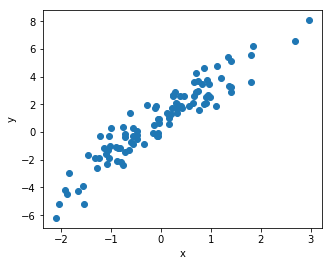

In [27]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(5,4))
axes.scatter(x, y)
axes.set_ylabel('y'); axes.set_xlabel('x');

## Bayesian linear regression model

In the following, we will assume that the data generation process was unknown to us. We will specify a regression model, train it on the dataset and attempt to recover the true values for $\alpha$ and $\beta$.

We use the following model:
\begin{align}
y &\sim \mathcal{N}(\mu,\,\sigma^{2}) \\
\mu &= \alpha + \beta x\\
\alpha &\sim \mathcal{N}(0,\,10^{2})\\
\beta &\sim \mathcal{N}(0,\,10^{2})\\
\sigma &= 1
\end{align}

The parameters of our model $\vec{\theta}=(\alpha, \beta)$ are given Gaussian priors $P(\vec{\theta})$.

The model uses a Gaussian likelihood $P(\vec{y}|\vec{X},\vec{\theta})$.

In this case, the posterior $P(\vec{\theta}|\vec{X},\vec{y})$ may be computed analytically because our prior is conjugate (i.e. the posterior is also Gaussian). However, let's assume that it isn't for the sake of this exercise.

In [87]:
# Set up prior distributions
alpha_mu_prior = 0
alpha_sigma_prior = 10
beta_mu_prior = 0
beta_sigma_prior = 10

alpha_prior = norm(alpha_mu_prior, alpha_sigma_prior)
beta_prior = norm(beta_mu_prior, beta_sigma_prior)

## Posterior analysis with MCMC
In MCMC, we obtain the posterior distribution by constructing an ergodic, reversible Markov chain that has an equilibrium distribution which matches our posterior. PyMC3 allows us to perform MCMC easily, but first we need to set-up our model.

In [14]:
import pymc3 as pm

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [88]:
basic_model = pm.Model()
with basic_model:

    # Priors for unknown model parameters
    alpha_model = pm.Normal('alpha', mu=alpha_mu_prior, sd=alpha_sigma_prior)
    beta_model = pm.Normal('beta', mu=beta_mu_prior, sd=beta_sigma_prior)
    
    # Compute mu by our model
    mu_model = alpha_model + beta_model*x

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal('Y_obs', mu=mu_model, sd=sigma, observed=y)

Using PyMC3, we can easily obtain a *maximum a posteriori* (MAP) estimate of $\vec{\theta}$. 

The MAP estimate is the mode of the posterior distribution, and can easily be found by optimisation methods. However, it only gives a point estimate of $\vec{\theta}$ and can be biased if the mode is not representative of the distribution. Ideally, we want to obtain the full posterior as it contains much more information about the uncertainty in our estimates. Furthermore, Bayesian inference uses the full posterior, instead of relying on a point estimate. 

\begin{align}
p(y^*\mid x^*,\vec{X},\vec{y}) &= \int p(y^*\mid x^*,\vec{\theta}) p(\vec{\theta}\mid\vec{X},\vec{y}) d\vec{\theta}
\end{align}

MCMC is a method of expressing the posterior distribution. Here, we will use the Metropolis-Hastings algorithm as our sampler, and run the chain for 5000 iterations.

In [85]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -494.99, ||grad|| = 271.7: 100%|██████████| 6/6 [00:00<00:00, 1006.35it/s]


{'alpha': array(0.92471872), 'beta': array(2.45655317)}

In [89]:
from scipy import optimize
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Metropolis()
    #step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/tuning/starting.py:91: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -138.77:   2%|▏         | 104/5000 [00:00<00:03, 1294.78it/s]


Optimization terminated successfully.
         Current function value: 138.766522
         Iterations: 3
         Function evaluations: 104


100%|██████████| 5500/5500 [00:01<00:00, 3745.74it/s]


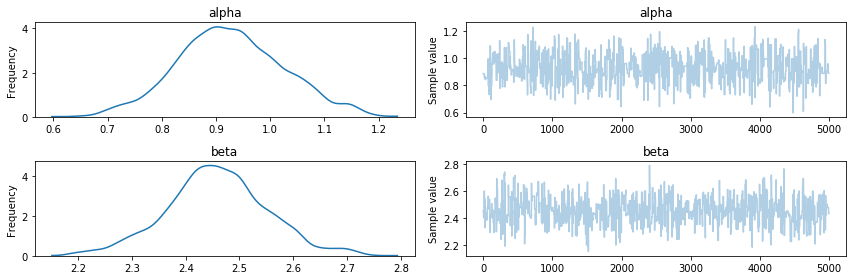

In [90]:
# Plot the posterior
_ = pm.traceplot(trace)

In [91]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.927            0.099            0.004            [0.760, 1.152]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.733          0.861          0.921          0.994          1.138


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.458            0.094            0.004            [2.270, 2.648]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.271          2.400          2.456          2.514          2.655



Note that the mean of the posterior distribution of $\alpha$ and $\beta$ has shifted towards the true values of $\alpha=1$ and $\beta=2.5$.

Furthermore, the standard deviation of the posterior reflects the uncertainty of the prediction. You can try changing the size of the dataset or the MCMC sampler, and see how that affects the mean and standard deviation of the posterior.

## Posterior analysis with importance sampling
In importance sampling, we obtain the posterior distribution with a Monte Carlo estimate by sampling values of $\vec{\theta}$ from a *proposal distribution* $q(\vec{\theta})$.

The proposal distribution offers an efficient way of performing Monte Carlo because it is chosen to be biased to "important" regions of the parameter space which contribute more to obtaining a good approximation. We then correct for this sampling bias by assigning weights to our samples according to a likelihood ratio. In particular, the weights are given by:

\begin{align}
w(\vec{\theta}^{(i)}) = \frac{p(\vec{y} \mid \vec{X},\vec{\theta}^{(i)})p(\vec{\theta}^{(i)})}{q(\vec{\theta}^{(i)})}
\end{align}

We use the following proposal distribution:
\begin{align}
q(\alpha) &= \mathcal{N}(0,3^{2}) \\
q(\beta) &= \mathcal{N}(0,3^{2})
\end{align}

In [127]:
num_samples = 5000

In [128]:
from scipy.stats import norm
# Set up proposal distributions
alpha_proposal = norm(0, 3)
beta_proposal = norm(0, 3)

In [129]:
alpha_sampled = alpha_proposal.rvs(num_samples)
beta_sampled = beta_proposal.rvs(num_samples)
p_likelihood = np.zeros((num_samples,))
weights = np.zeros((num_samples,))
for i in range(num_samples):
    # Obtain sampled alpha and beta
    alpha_star = alpha_sampled[i]
    beta_star = beta_sampled[i]
    
    # Compute mu using our model
    mu_star = alpha_star + beta_star*x
    
    # Calculate likelihood p(y|x,theta)
    likelihood = norm(mu_star, sigma)
    p_likelihood[i] = np.prod(likelihood.pdf(y))
    
p_prior = np.multiply(alpha_prior.pdf(alpha_sampled), beta_prior.pdf(beta_sampled))
p_proposal = np.multiply(alpha_proposal.pdf(alpha_sampled), beta_proposal.pdf(beta_sampled))

# Compute weights = p(y|x,theta)*p(theta) / q(theta)
weights = np.multiply(p_likelihood,  p_prior) / p_proposal

MCMC posterior for alpha: mean=0.9271767077295774, std=0.09871992598287566


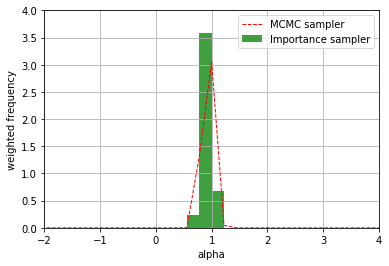

In [134]:
# Plot posterior of alpha
n, bins, patches = plt.hist(alpha_sampled, bins=100, normed=1, weights=weights, facecolor='green', alpha=0.75, label='Importance sampler')

# Compare with MCMC prediction
alpha_mu_mcmc = np.mean(trace['alpha'])
alpha_sigma_mcmc = np.std(trace['alpha'])
y_plot = mlab.normpdf(bins, alpha_mu_mcmc, alpha_sigma_mcmc)
plt.plot(bins, y_plot, 'r--', linewidth=1, label='MCMC sampler')

plt.axis([-2, 4, 0, 4])
plt.grid(True)
plt.ylabel('weighted frequency'); plt.xlabel('alpha');
plt.legend()
print("MCMC posterior for alpha: mean={}, std={}".format(alpha_mu_mcmc,alpha_sigma_mcmc))

MCMC posterior for beta: mean=2.4583933561043168, std=0.09356267366191276


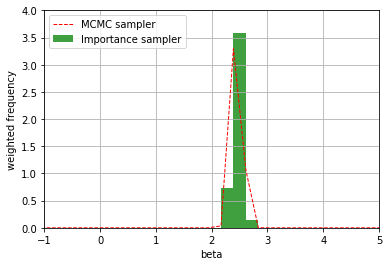

In [136]:
# Plot posterior of beta
n, bins, patches = plt.hist(beta_sampled, bins=100, normed=1, weights=weights, facecolor='green', alpha=0.75, label='Importance sampler')

# Compare with MCMC prediction
beta_mu_mcmc = np.mean(trace['beta'])
beta_sigma_mcmc = np.std(trace['beta'])
y_plot = mlab.normpdf(bins, beta_mu_mcmc, beta_sigma_mcmc)
l = plt.plot(bins, y_plot, 'r--', linewidth=1, label='MCMC sampler')

plt.axis([-1, 5, 0, 4])
plt.grid(True)
plt.ylabel('weighted frequency'); plt.xlabel('beta');
plt.legend()
print("MCMC posterior for beta: mean={}, std={}".format(beta_mu_mcmc,beta_sigma_mcmc))

## Summary
We have demonstrated posterior analysis using two Monte Carlo methods: MCMC and importance sampling. Below are some concluding remarks:
 - Try applying the above to a non-conjugate model. eg Bernoulli likelihood with Gaussian priors
 - How to choose a proposal distribution for importance sampling? eg cross-validation, minimise variance
 - What are the differences between MCMC and importance sampling? eg MCMC better in higher dimensions
 - How to use the obtained posterior for inference?

## References
1. Theory: https://www.youtube.com/watch?v=TNZk8lo4e-Q
2. PyMC3: http://docs.pymc.io/notebooks/getting_started.html#A-Motivating-Example:-Linear-Regression
3. MCMC example: http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
4. Importance sampling example: https://github.com/kevinzakka/monte-carlo/blob/master/Monte%20Carlo%20and%20Importance%20Sampling.ipynb